# Dialog act classification using attention model

In [1]:
#Libraries
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Permute, Flatten, Activation, RepeatVector, Permute, Multiply, Lambda
from keras import backend as K
import seaborn

In [2]:
#Copy the path of your train.csv file
data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\train.csv')
print(data.shape)
data.head(3)

(75066, 6)


,Unnamed: 0,Speaker,Utterances,Basic,General,Full
0,0,fe016,so um,F,fh,fh
1,1,fe016,i was going to try to get out of here like in ...,S,s,rt
2,2,fe016,um,F,fh,fh


In [3]:
data=data.drop(columns=["Unnamed: 0"])
data.head(3)

,Speaker,Utterances,Basic,General,Full
0,fe016,so um,F,fh,fh
1,fe016,i was going to try to get out of here like in ...,S,s,rt
2,fe016,um,F,fh,fh


In [4]:
data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
data['Utterances'].head(3)

0                                                so um
1    i was going to try to get out of here like in ...
2                                                   um
Name: Utterances, dtype: object

In [5]:
#Creating table of number of each data label present in the dataset
label_count=data.groupby('Basic')['Basic'].agg('count')
label_count.to_numpy(dtype=int)
label_count = np.expand_dims(label_count, axis=0)
label_count.shape=(5,1)
labels=np.array(['B', 'D', 'F', 'Q', 'S'])
labels.shape=(5,1)
label_count=np.column_stack((labels,label_count))

df = pd.DataFrame(label_count, columns=['Label', 'Count'])

convert_dict = {'Label': str,
                'Count': int
               }
  
df = df.astype(convert_dict)
df

,Label,Count
0,B,10265
1,D,9739
2,F,5323
3,Q,4640
4,S,45099


<AxesSubplot:xlabel='Label'>

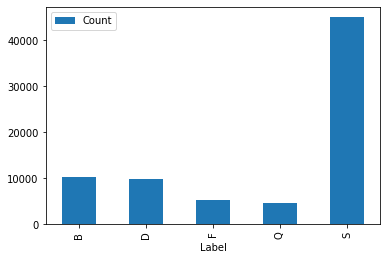

In [6]:
df.plot.bar(x = 'Label', y='Count')

In [7]:
#Tokenizing the words and padding the sentence
MAX_PADDING = 100
tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(data['Utterances'].values)
x_train = tokenizer.texts_to_sequences(data['Utterances'].values)
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_PADDING)
print(x_train.shape)
x_train[:2]

(75066, 100)


array([[ 11,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  36,  58,   4, 170,   4,  61,  83,  10,  96,  34,  15, 441,
         87, 741,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [8]:
from keras import layers

MAX_LENGTH_PER_SENTENCE=100
units = 128
encoder_input = keras.Input(shape=(MAX_LENGTH_PER_SENTENCE))
x =layers.Embedding(input_dim=5000, output_dim=256, input_length=x_train.shape[1])(encoder_input)
                              
activations = Bidirectional(tf.keras.layers.LSTM(units, dropout=0.3, recurrent_dropout=0.2))(x)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units*2)(attention)
attention = Permute((2, 1))(attention)

sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)


probabilities = Dense(5, activation='softmax')(sent_representation)


encoder = keras.Model(inputs=[encoder_input], outputs=[probabilities],name='encoder')

In [9]:
encoder.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 256)     1280000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          394240      embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            257         bidirectional[0][0]              
____________________________________________________________________________________________

In [10]:
y_train = pd.get_dummies(data['Basic']).values
[print(data['Basic'][i],y_train[i]) for i in range (0,5)]

F [0 0 1 0 0]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]
S [0 0 0 0 1]


[None, None, None, None, None]

In [11]:
#Validation set processing
val_set = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\val.csv')
val_set = val_set.drop(columns=["Unnamed: 0"])
val_set['Utterances'] = val_set['Utterances'].apply(lambda x: x.lower())
val_set['Utterances'] = val_set['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(val_set['Utterances'].values)
x_val = tokenizer.texts_to_sequences(val_set['Utterances'].values)
x_val = pad_sequences(x_val, padding='post', maxlen=MAX_PADDING)

y_val = pd.get_dummies(val_set['Basic']).values

In [12]:
#Early stopping the training when accuracy decreases
es = keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', patience=1, verbose=1)


encoder.fit(x_train, y_train, 
          epochs=10000, 
          batch_size=32, 
          verbose=1, 
          callbacks=[es], 
          validation_data=(x_val, y_val))

Epoch 1/10000
2346/2346 [==============================] - 1091s 463ms/step - loss: 0.6207 - accuracy: 0.7704 - val_loss: 1.3593 - val_accuracy: 0.5265
Epoch 2/10000
2346/2346 [==============================] - 1077s 459ms/step - loss: 0.5243 - accuracy: 0.8051 - val_loss: 1.5538 - val_accuracy: 0.5211
Epoch 3/10000
2346/2346 [==============================] - 1075s 458ms/step - loss: 0.4889 - accuracy: 0.8177 - val_loss: 1.7035 - val_accuracy: 0.5090
Epoch 4/10000
2346/2346 [==============================] - 1077s 459ms/step - loss: 0.4621 - accuracy: 0.8262 - val_loss: 1.6295 - val_accuracy: 0.4930
Epoch 5/10000
2346/2346 [==============================] - 1076s 459ms/step - loss: 0.4398 - accuracy: 0.8328 - val_loss: 1.5529 - val_accuracy: 0.5063
Epoch 6/10000
2346/2346 [==============================] - 1078s 459ms/step - loss: 0.4184 - accuracy: 0.8395 - val_loss: 1.6170 - val_accuracy: 0.4914
Epoch 7/10000
2346/2346 [==============================] - 1081s 461ms/step - loss: 0.40

In [13]:
#Test set processing
test_set = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\test.csv')
test_set = test_set.drop(columns=["Unnamed: 0"])
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: x.lower())
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(test_set['Utterances'].values)
x_test = tokenizer.texts_to_sequences(test_set['Utterances'].values)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_PADDING)

y_test = pd.get_dummies(test_set['Basic']).values
[print(test_set['Basic'][i],y_test[i]) for i in range (0,5)]

S [0 0 0 0 1]
S [0 0 0 0 1]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]


[None, None, None, None, None]

In [14]:
score = encoder.evaluate(x_test, y_test)

522/522 [==============================] - 30s 57ms/step - loss: 2.5230 - accuracy: 0.5446


In [17]:
#Saving the model
encoder.save('BiLSTMAttention.h5')

In [19]:
#Loading the saved model
model1 = load_model('BiLSTMAttention.h5')
y_pred = model1.predict(x_test)
print(y_pred[1])

[2.0116513e-05 9.4897676e-01 1.2832701e-04 3.5388742e-02 1.5486029e-02]


In [20]:
x_test[1]=np.array(x_test[1])
x_test[1].reshape(1, 100)

array([[52, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])

In [21]:
y_pred = np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\pycm\pycm_obj.py:951: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

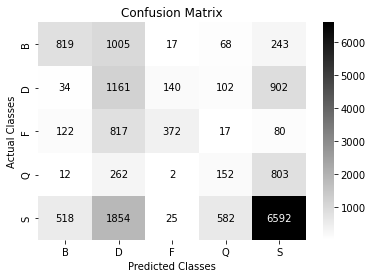

In [22]:
from pycm import *
cm = ConfusionMatrix(y_test, y_pred,digit=5)
cm.relabel(mapping={0:"B",1:"D",2:"F",3:"Q",4:"S"})
cm.plot(plot_lib = "seaborn",number_label=True)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

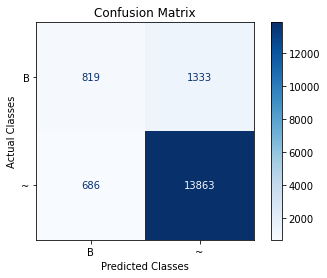

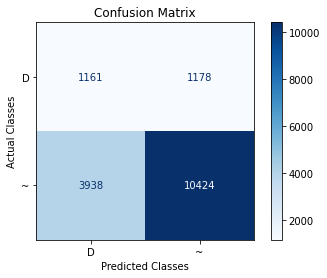

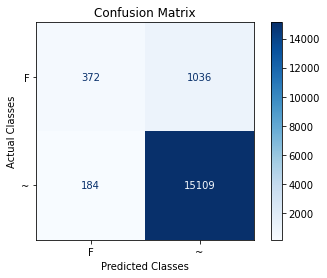

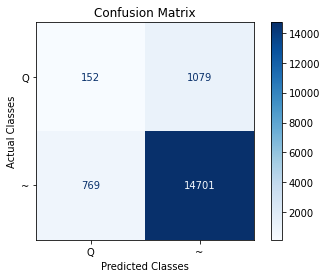

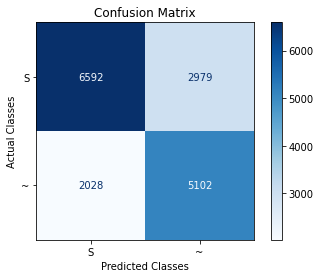

In [23]:
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="B")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="D")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="F")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="Q")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="S")

In [24]:
DA = np.array(['B','D','F','Q','S'])
a = ["will you go"]
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=MAX_PADDING)
prediction = model1.predict(np.array(a))
DA[prediction.argmax(1)]

array(['D'], dtype='<U1')